#### 数据来源：某企业销售的6种商品所对应的送货及用户反馈数据
-  解决问题：
1. 配送服务是否存在问题
2. 是否存在尚有潜力的销售区域
3. 商品是否存在质量问题

- 先放结论：
1. 货品4→西北，货品2→马来西亚两条线路存在较大问题，急需提升时效
2. 货品2在华东地区还有较大市场空间，适合加大投入，同时货品2在西北配送时效长，用户拒收率高，从成本角度考虑，应该减少投入
3. 货品1、2、4质量存在问题，建议扩大抽检范围，增大质检力度

- 分析过程如下
1.  数据清洗
    - ① 重复值、缺失值、格式调整(消费金额单位不统一并且是字符型数据)
    - ② 异常值处理（比如：销售金额存在等于0的，这种情况不存在，也就是不会存在销售金额为0的情况，是个异常值，数量和销售金额的标准差都在均值的8倍以上等）
2. 数据规整
    - 比如：增加一项辅助列：月份
3. 数据分析并可视化

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']='SimHei' ##设置中文显示

1.  数据清洗
    - ① 重复值、缺失值、格式调整(消费金额单位不统一并且是字符型数据)

In [8]:
data=pd.read_csv(r"C:\Users\23665\Desktop\研一上课资料\111\数据分析\数据分析实战\data_wuliu.csv",encoding='gbk')
data.info()
#10列，订单号、销售数量有NA值，把并且NA的个数比较少，所以可以将其删除
#object 类型不能直接参与运算

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单号     1159 non-null   object 
 1   订单行     1161 non-null   int64  
 2   销售时间    1161 non-null   object 
 3   交货时间    1161 non-null   object 
 4   货品交货状况  1159 non-null   object 
 5   货品      1161 non-null   object 
 6   货品用户反馈  1161 non-null   object 
 7   销售区域    1161 non-null   object 
 8   数量      1157 non-null   float64
 9   销售金额    1161 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 90.8+ KB


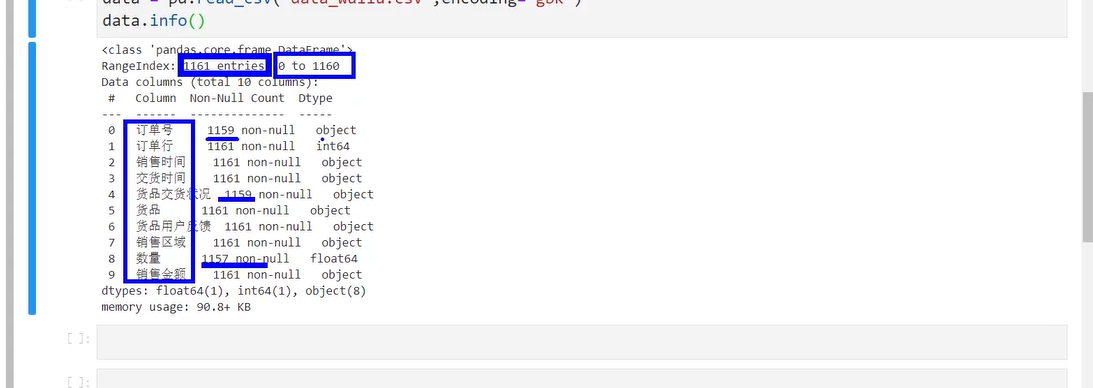
- 通过info()可以看出包括10列数据，名字、数据量、格式等，可以得出：
1. 订单号，货品交货情况，数量：存在缺失值，但缺失值比较少可以删除
2. 订单行，对分析无关紧要可以考虑删除
3. 销售金额格式不对（万元，元，逗号问题），数据类型需要转换成int|float

In [9]:
#删除重复记录
data.drop_duplicates(keep='first',inplace=True)
data.info()
#删除缺失值（只要一行数据中带有NA就将该行删除）
data.dropna(axis=0,how='any',inplace=True) #how='any'（默认值）只要有一个是缺失值就将其删除，all是所有都是缺失值时候才将其删除
data.info()
#删除订单行,重复删除会报错，所以需要重新加载数据
data.drop(columns=['订单行'],inplace=True,axis=1)
data #此时索引认识之前的，也就是不连贯的
#更新索引
data=data.reset_index(drop=True) #rop=True丢掉原来的索引列重新添加索引

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1160
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单号     1150 non-null   object 
 1   订单行     1152 non-null   int64  
 2   销售时间    1152 non-null   object 
 3   交货时间    1152 non-null   object 
 4   货品交货状况  1150 non-null   object 
 5   货品      1152 non-null   object 
 6   货品用户反馈  1152 non-null   object 
 7   销售区域    1152 non-null   object 
 8   数量      1150 non-null   float64
 9   销售金额    1152 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 99.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 0 to 1160
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单号     1146 non-null   object 
 1   订单行     1146 non-null   int64  
 2   销售时间    1146 non-null   object 
 3   交货时间    1146 non-null   object 
 4   货品交货状况  1146 non-null   object 
 5   货品      1146 no

In [10]:
data.head()

,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额
0,P096311,2016/7/30,2016/9/30,晚交货,货品3,质量合格,华北,2.0,"1052,75元"
1,P096826,2016/8/30,2016/10/30,按时交货,货品3,质量合格,华北,10.0,"11,50万元"
2,P097435,2016/7/30,2016/9/30,按时交货,货品1,返修,华南,2.0,"6858,77元"
3,P097446,2016/11/26,2017/1/26,晚交货,货品3,质量合格,华北,15.0,"129,58元"
4,P097446,2016/11/26,2017/1/26,晚交货,货品3,拒货,华北,15.0,"32,39元"


In [13]:
#修改金额格式：没有现有的函数满足需求，就需要自己写函数来完成格式修改
#取出销售金额列，对每个数据进行清洗，因为每个数据的类型是不一样的（元，万元）
#编写自定义过滤函数，删除逗号，转成float,如果是万元乘以10000，并且删除万元，否则删除元
def data_deal(number): #find是针对字符串的，不能针对float类型
    if number.find('万元')!=-1: #找到带有万元的，取出数字，去掉逗号，转成float,*10000,number.find('万元')表示找到万元的索引应该是-2
        number_new=float(number[:number.find('万元')].replace(',',''))*10000
        pass
    else: #找到带有元的删除元，删除逗号，转成float
        number_new=float(number.replace('元','').replace(',',''))
        pass
    return number_new
data['销售金额']=data['销售金额'].map(data_deal)
data
#与原数字检查看是否转换正确

,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额
0,P096311,2016/7/30,2016/9/30,晚交货,货品3,质量合格,华北,2.0,105275.0
1,P096826,2016/8/30,2016/10/30,按时交货,货品3,质量合格,华北,10.0,11500000.0
2,P097435,2016/7/30,2016/9/30,按时交货,货品1,返修,华南,2.0,685877.0
3,P097446,2016/11/26,2017/1/26,晚交货,货品3,质量合格,华北,15.0,12958.0
4,P097446,2016/11/26,2017/1/26,晚交货,货品3,拒货,华北,15.0,3239.0
...,...,...,...,...,...,...,...,...,...
1141,P299901,2016/12/15,2017/3/15,按时交货,货品6,质量合格,马来西亚,2.0,20041.0
1142,P302956,2016/12/22,2017/3/22,按时交货,货品2,拒货,华东,20.0,7944.0
1143,P303801,2016/12/15,2017/3/15,按时交货,货品2,质量合格,华东,1.0,19408.0
1144,P307276,2016/12/22,2017/3/22,按时交货,货品6,质量合格,马来西亚,1.0,3218.0


- ② 异常值处理（比如：销售金额存在等于0的，这种情况不存在，也就是不会存在销售金额为0的情况，是个异常值，数量和销售金额的标准差都在均值的8倍以上等）

In [14]:
data.describe() #数据的描述性分析
#根据数量的描述性统计分析可以知道数据发生了右偏，也就是小的值很多，大的值很少
#看原表格数据即可知道
#销售金额：50%分位数远远小于中位数，所有也是发生了右偏

,数量,销售金额
count,1146.000000,1.146000e+03
mean,76.069372,1.223488e+05
std,589.416486,1.114599e+06
min,1.000000,0.000000e+00
25%,1.000000,2.941500e+03
50%,1.000000,9.476500e+03
75%,4.000000,3.576775e+04
max,11500.000000,3.270000e+07


- 数据右偏：众数远远小于中位数
- 数据左偏：众数数远远大于中位数
- 对称分布：均值与中位数差不多
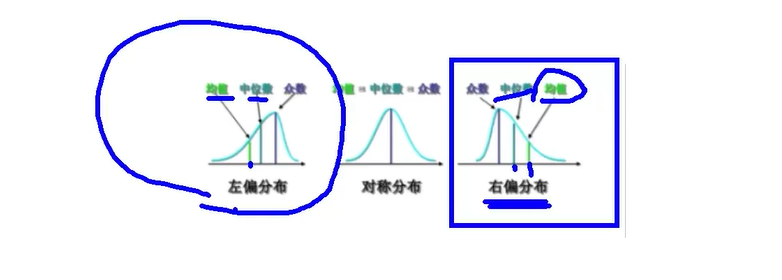
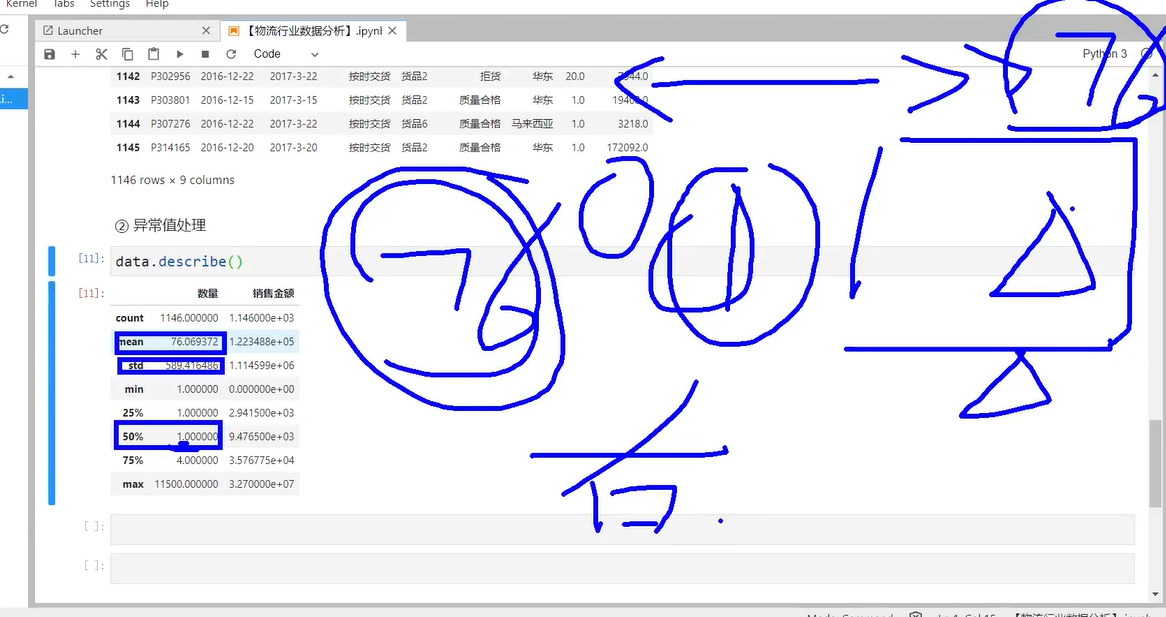
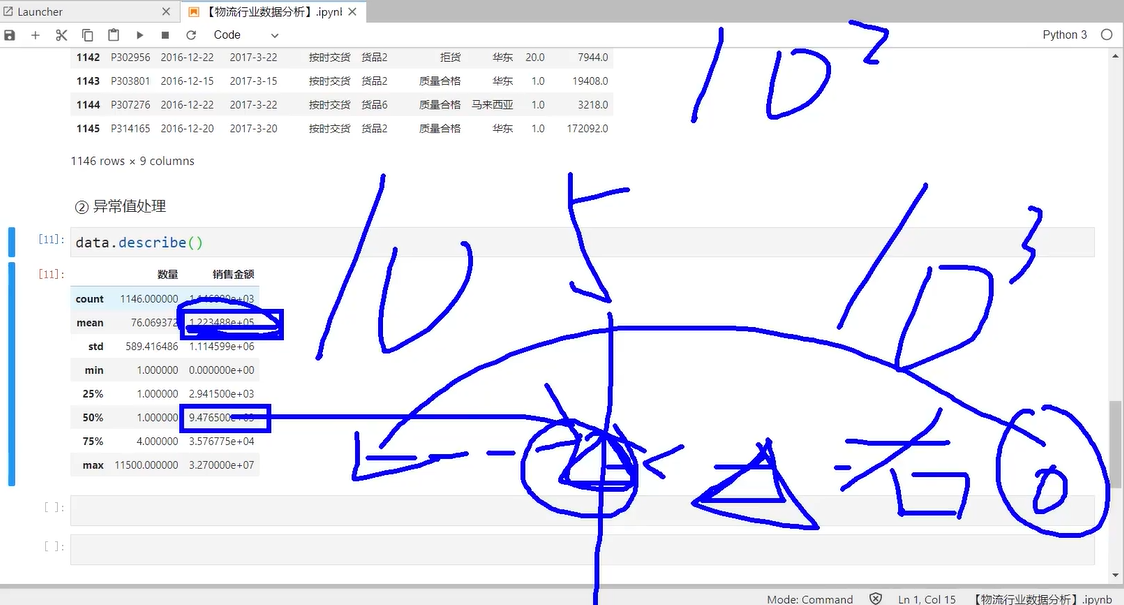


In [15]:
#销售金额为0，删除，因为数据量很小
data=data[data['销售金额']!=0]
data.describe()
#2.8法则：销售金额与数量存在严重右偏现象，在电商领域很正常，无需处理

,数量,销售金额
count,1145.000000,1.145000e+03
mean,76.134934,1.224557e+05
std,589.669861,1.115081e+06
min,1.000000,5.100000e+01
25%,1.000000,2.946000e+03
50%,1.000000,9.486000e+03
75%,4.000000,3.577300e+04
max,11500.000000,3.270000e+07


2. 数据规整
    - 比如：增加一项辅助列：月份
    - 因为分析配送服务是否存在问题，是否存在潜在的销售区域都是按照月份进行分析的
    - 销售时间提取月份

In [16]:
data['销售时间']=pd.to_datetime(data['销售时间']) #转变为时间类型（原来是object类型）
data.info()
data['月份']=data['销售时间'].apply(lambda x:x.month) #对销售时间列每个数据都执行apply里面的函数
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 0 to 1145
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   订单号     1145 non-null   object        
 1   销售时间    1145 non-null   datetime64[ns]
 2   交货时间    1145 non-null   object        
 3   货品交货状况  1145 non-null   object        
 4   货品      1145 non-null   object        
 5   货品用户反馈  1145 non-null   object        
 6   销售区域    1145 non-null   object        
 7   数量      1145 non-null   float64       
 8   销售金额    1145 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 89.5+ KB


C:\Users\23665\AppData\Local\Temp\ipykernel_40768\2199464587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['销售时间']=pd.to_datetime(data['销售时间']) #转变为时间类型（原来是object类型）
C:\Users\23665\AppData\Local\Temp\ipykernel_40768\2199464587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['月份']=data['销售时间'].apply(lambda x:x.month) #对销售时间列每个数据都执行apply里面的函数


,订单号,销售时间,交货时间,货品交货状况,货品,货品用户反馈,销售区域,数量,销售金额,月份
0,P096311,2016-07-30,2016/9/30,晚交货,货品3,质量合格,华北,2.0,105275.0,7
1,P096826,2016-08-30,2016/10/30,按时交货,货品3,质量合格,华北,10.0,11500000.0,8
2,P097435,2016-07-30,2016/9/30,按时交货,货品1,返修,华南,2.0,685877.0,7
3,P097446,2016-11-26,2017/1/26,晚交货,货品3,质量合格,华北,15.0,12958.0,11
4,P097446,2016-11-26,2017/1/26,晚交货,货品3,拒货,华北,15.0,3239.0,11
...,...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017/3/15,按时交货,货品6,质量合格,马来西亚,2.0,20041.0,12
1142,P302956,2016-12-22,2017/3/22,按时交货,货品2,拒货,华东,20.0,7944.0,12
1143,P303801,2016-12-15,2017/3/15,按时交货,货品2,质量合格,华东,1.0,19408.0,12
1144,P307276,2016-12-22,2017/3/22,按时交货,货品6,质量合格,马来西亚,1.0,3218.0,12


-  解决问题：
1.配送服务是否存在问题

a. 月份维度


3.商品是否存在质量问题

In [17]:
data['货品交货状况']=data['货品交货状况'].str.strip() #去除空格，分析货品交货状况列可以看到有的是数据前面存在空格
data2=data.groupby(['月份','货品交货状况']).size()  #分组之后的计数，.size()包括缺失值，.count()不包括缺失值
data1=data.groupby(['月份','货品交货状况']).size().unstack()
print(data2)
print(data1)
#计算按时交货率
data1['按时交货率']=data1['按时交货']/(data1['按时交货']+data1['晚交货'])
data1
#789月份高于其他月份，也就是秋季（第三季度）大于冬季（第四季度），猜测可能是季节的原因

月份  货品交货状况
7   按时交货      189
    晚交货        13
8   按时交货      218
    晚交货        35
9   按时交货      122
    晚交货         9
10  按时交货      238
    晚交货        31
11  按时交货      101
    晚交货        25
12  按时交货      146
    晚交货        18
dtype: int64
货品交货状况  按时交货  晚交货
月份               
7        189   13
8        218   35
9        122    9
10       238   31
11       101   25
12       146   18


C:\Users\23665\AppData\Local\Temp\ipykernel_40768\3856669497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['货品交货状况']=data['货品交货状况'].str.strip() #去除空格，分析货品交货状况列可以看到有的是数据前面存在空格


货品交货状况,按时交货,晚交货,按时交货率
月份,,,
7,189,13,0.935644
8,218,35,0.861660
9,122,9,0.931298
10,238,31,0.884758
11,101,25,0.801587
12,146,18,0.890244


b. 销售区域维度

In [41]:
data1=data.groupby(['销售区域','货品交货状况']).size().unstack()
data2
data1
#计算按时交货率
data1['按时交货率']=data1['按时交货']/(data1['按时交货']+data1['晚交货'])
print(data1.sort_values(by='按时交货率',ascending=False)) #按照交货率降序排序
#西北存在严重的延时交货问题，急需解决

货品交货状况  按时交货  晚交货     按时交货率
销售区域                       
泰国       183    4  0.978610
马来西亚     310   16  0.950920
华南        10    1  0.909091
华北       226   27  0.893281
华东       268   39  0.872964
西北        17   44  0.278689


c.货品维度

In [42]:
data1=data.groupby(['货品','货品交货状况']).size().unstack()
data2
data1
#计算按时交货率
data1['按时交货率']=data1['按时交货']/(data1['按时交货']+data1['晚交货'])
print(data1.sort_values(by='按时交货率',ascending=False))
#货品4玩交货的情况非常严重，其余的相对较好

货品交货状况  按时交货  晚交货     按时交货率
货品                         
货品5      183    4  0.978610
货品6      309    7  0.977848
货品1       27    2  0.931034
货品3      212   26  0.890756
货品2      269   48  0.848580
货品4       14   44  0.241379


d.货品和销售区域结合

In [43]:
data1=data.groupby(['货品','销售区域','货品交货状况']).size().unstack()
data2
data1
#计算按时交货率
data1['按时交货率']=data1['按时交货']/(data1['按时交货']+data1['晚交货'])
print(data1.sort_values(by='按时交货率',ascending=False))
#销售区上看：最差在西北地区，货品有1和4，主要是由于货品4送货较晚导致
#货品角度：最差是货品2，主要送往华东和马来西亚，主要是马来西亚送货较晚导致

货品交货状况     按时交货   晚交货     按时交货率
货品  销售区域                       
货品5 泰国    183.0   4.0  0.978610
货品6 马来西亚  309.0   7.0  0.977848
货品1 华北     14.0   1.0  0.933333
    华南     10.0   1.0  0.909091
货品3 华北    212.0  26.0  0.890756
货品2 华东    268.0  39.0  0.872964
货品4 西北     14.0  44.0  0.241379
货品2 马来西亚    1.0   9.0  0.100000
货品1 西北      3.0   NaN       NaN


2.是否存在尚有潜力的销售区域

a. 月份维度（每个月的每个商品销售情况）

<Axes: xlabel='月份'>

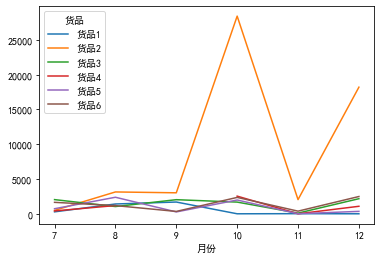

In [47]:
data1=data.groupby(['月份','货品'])['数量'].sum().unstack() #分组之后对数量求和,.unstack将结果转成行的形式
data1
data1.plot(kind='line') #折线图
#货品2在10、12月份销量比较大，会不会是因公司加大了对他的推广力度、公司开发了新的市场

b.不同区域

In [49]:
data1=data.groupby(['销售区域','货品'])['数量'].sum().unstack() #分组之后对数量求和,.unstack将结果转成行的形式
data1
#data1.plot(kind='line') #折线图
#从销售区域上看，每个货品的销售区域一般是1--3个区域，1有3个销售区域，2有2个销售区域

货品,货品1,货品2,货品3,货品4,货品5,货品6
销售区域,,,,,,
华东,NaN,53811.0,NaN,NaN,NaN,NaN
华北,2827.0,NaN,9073.5,NaN,NaN,NaN
华南,579.0,NaN,NaN,NaN,NaN,NaN
泰国,NaN,NaN,NaN,NaN,5733.0,NaN
西北,11.0,NaN,NaN,5229.0,NaN,NaN
马来西亚,NaN,1510.0,NaN,NaN,NaN,8401.0


c. 月份和区域

In [51]:
data1=data.groupby(['月份','销售区域','货品'])['数量'].sum().unstack()
data1
data1['货品2'] #查看货品2的销售情况
#货品2的销量在10，11，12月份在华东地区猛增，可以看到前面的结论公司加大了对他的推广力度是错误的，所以货品2在10、12月份销售量猛增的原因在华东地区加大了推广力度
#为什么在7、8、9、11月份销量这么低：因为没有加大推广力度，所以在这四个月份也加大推广力度


月份  销售区域
7   华东        489.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        2.0
8   华东       1640.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚     1503.0
9   华东       3019.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        1.0
10  华东      28420.0
    华北          NaN
    泰国          NaN
    西北          NaN
    马来西亚        NaN
11  华东       2041.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        1.0
12  华东      18202.0
    华北          NaN
    华南          NaN
    泰国          NaN
    西北          NaN
    马来西亚        3.0
Name: 货品2, dtype: float64

3. 商品是否存在质量问题
- 根据货品的用户放映情况分析

In [60]:
#在每次分析时候建议将首尾的空格删除
data['货品用户反馈']=data['货品用户反馈'].str.strip() #删除首尾空格
data1=data.groupby(['货品','销售区域'])['货品用户反馈'].value_counts().unstack() #因为是字符串，所以不能统计数量，这里是取值的统计
data1
#print(data1.sum(axis=1)) #在分组之后的总数
#print(data1.sum())
data1['拒货率']=data1['拒货']/data1.sum(axis=1) #按照行求和
data1['返修率']=data1['返修']/data1.sum(axis=1)
data1['合格率']=data1['质量合格']/data1.sum(axis=1)
data1.sort_values(['合格率','返修率','拒货率'],ascending=False)

C:\Users\23665\AppData\Local\Temp\ipykernel_105880\3531172168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['货品用户反馈']=data['货品用户反馈'].str.strip() #删除首尾空格


货品用户反馈      拒货   质量合格    返修       拒货率       返修率       合格率
货品  销售区域                                                 
货品3 华北    31.0  188.0  19.0  0.130252  0.079788  0.789219
货品6 马来西亚  56.0  246.0  14.0  0.177215  0.044279  0.777936
货品5 泰国    14.0  144.0  29.0  0.074866  0.155018  0.769108
货品2 华东    72.0  184.0  51.0  0.234528  0.165997  0.598568
货品1 华南     5.0    4.0   2.0  0.454545  0.174603  0.343963
    西北     NaN    1.0   2.0       NaN  0.666667  0.272727
    华北     NaN    3.0  12.0       NaN  0.800000  0.189873
货品4 西北     NaN    9.0  49.0       NaN  0.844828  0.152945
货品2 马来西亚   6.0    1.0   3.0  0.600000  0.283019  0.091886

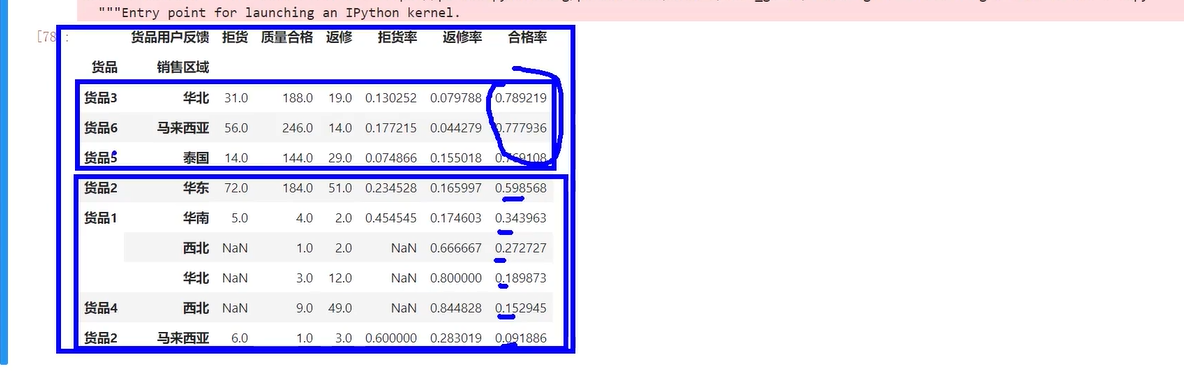
- 说明3、6、5的合格率比较高，返修率比较低，说明质量是可以的
- 1、2、4合格率较低、返修率较高、说明质量存在一定问题需要改善
- 货品2在马来西亚的拒货率最高，根据前面分析知货品2在马来西亚按时交货率非常低，猜测马来西亚人对送货的时效性要求比较高，如果达不到，往往考虑拒绝收货
- 考虑到货品2主要在华东地区销售，可以考虑货品2在马来西亚的投送，增大对华东地区的投资